# Text Classification - ELMo

ELMo is a deep contextualized word representation that models both (1) complex characteristics of word use (e.g., syntax and semantics), and (2) how these uses vary across linguistic contexts (i.e., to model polysemy). These word vectors are learned functions of the internal states of a deep bidirectional language model (biLM), which is pre-trained on a large text corpus. They can be easily added to existing models and significantly improve the state of the art across a broad range of challenging NLP problems, including question answering, textual entailment and sentiment analysis.

In [1]:
# load packages
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics

import keras
from keras.models import Sequential,Model
from keras.layers import  Input,Embedding, Lambda,Dropout,Conv1D,Conv2D,Activation, Dense, Bidirectional,GlobalMaxPooling1D, LSTM, SpatialDropout1D, TimeDistributed,Masking,Layer
from keras.callbacks import ModelCheckpoint
import keras.backend as K

from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import string
import pandas as pd
from nltk.stem.porter import PorterStemmer
import re
import spacy
from nltk.corpus import stopwords
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
from spacy.lang.en import English
spacy.load('en')
parser = English()

Using TensorFlow backend.


In [2]:
# Stop words and special characters 
STOPLIST = set(stopwords.words('english') + list(ENGLISH_STOP_WORDS)) 
SYMBOLS = " ".join(string.punctuation).split(" ") + ["-", "...", "”", "”","''"]

In [3]:
trainDF = pd.read_csv('./bbc-text.csv')

In [4]:
trainDF.head(10)

,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...
5,politics,howard hits back at mongrel jibe michael howar...
6,politics,blair prepares to name poll date tony blair is...
7,sport,henman hopes ended in dubai third seed tim hen...
8,sport,wilkinson fit to face edinburgh england captai...
9,entertainment,last star wars not for children the sixth an...


In [5]:
trainDF.shape

(2225, 2)

In [6]:
# change datatype to string
trainDF = trainDF[["category","text"]].astype(str)

In [7]:
# check labels in category
trainDF['category'].unique()

array(['tech', 'business', 'sport', 'entertainment', 'politics'],
      dtype=object)

In [8]:
# check counts of each category
trainDF['category'].value_counts()

sport            511
business         510
politics         417
tech             401
entertainment    386
Name: category, dtype: int64

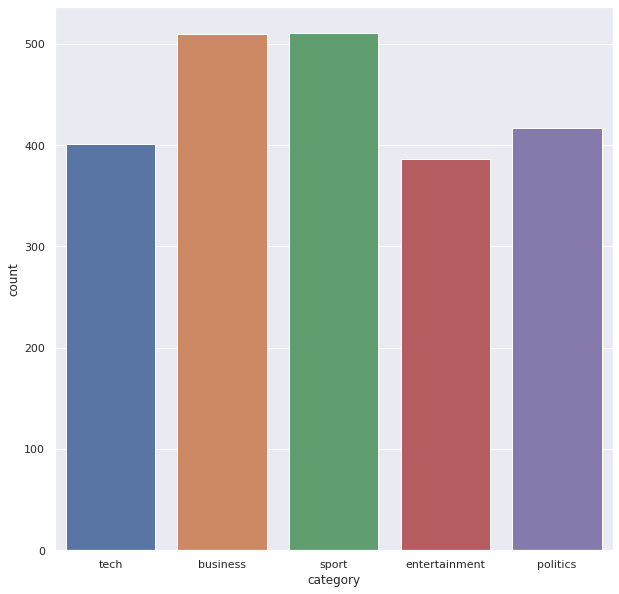

In [9]:
sns.set(rc={'figure.figsize':(10,10)})
sns.countplot(trainDF['category'])

## Data preparation

In [10]:
# Data Cleaner and tokenizer
def tokenizeText(text):

    text = text.strip().replace("\n", " ").replace("\r", " ")
    text = text.lower()
    
    tokens = parser(text)
    
    lemmas = []
    for tok in tokens:
        lemmas.append(tok.lemma_.lower().strip() if tok.lemma_ != "-PRON-" else tok.lower_)
    tokens = lemmas
    
    # reomve stop words and special charaters
    tokens = [tok for tok in tokens if tok.lower() not in STOPLIST]
    tokens = [tok for tok in tokens if tok not in SYMBOLS]
    
    tokens = [tok for tok in tokens if len(tok) >= 3]
    
    # remove remaining tokens that are not alphabetic
    tokens = [tok for tok in tokens if tok.isalpha()]
    
    # stemming of words
    #porter = PorterStemmer()
    #tokens = [porter.stem(word) for word in tokens]
    
    tokens = list(set(tokens))
    #return tokens
    return ' '.join(tokens[:])

In [11]:
# Data cleaning
trainDF['text'] = trainDF['text'].apply(lambda x:tokenizeText(x))

In [12]:
# label encoding

y = list(trainDF['category'])
x = list(trainDF['text'])

le = preprocessing.LabelEncoder()
le.fit(y)

def encode(le, labels):
    enc = le.transform(labels)
    return keras.utils.to_categorical(enc)

def decode(le, one_hot):
    dec = np.argmax(one_hot, axis=1)
    return le.inverse_transform(dec)


x_enc = x
y_enc = encode(le, y)

In [13]:
# split the dataset into training and validation datasets
x_train, x_val, y_train, y_val = model_selection.train_test_split(np.asarray(x_enc), np.asarray(y_enc), test_size=0.2, random_state=42)

In [14]:
# split the dataset into training and validation datasets
x_train, x_test, y_train, y_test = model_selection.train_test_split(x_train, y_train, test_size=0.2, random_state=42)

In [15]:
x_train.shape,x_val.shape, x_test.shape

((1424,), (445,), (356,))

## Model Building

In [16]:
import tensorflow_hub as hub
import tensorflow as tf
tf.compat.v1.get_default_graph
from keras.layers.merge import add

In [17]:
embed = hub.Module("/home/saiy/Documents/work_files/extras/embeddings/elmo", trainable=True)

In [27]:
def ELMoEmbedding(x):
    return embed(tf.squeeze(tf.cast(x, tf.string)), signature="default", as_dict=True)["elmo"]

In [19]:
class ElmoEmbeddingLayer(Layer):
    def __init__(self, **kwargs):
        self.dimensions = 1024
        self.trainable = True
        super(ElmoEmbeddingLayer, self).__init__(**kwargs)
        
    def build(self, input_shape):
            self.elmo = hub.Module("/home/saiy/Documents/work_files/extras/embeddings/elmo", trainable=self.trainable, name="{}_module".format(self.name))
            self.trainable_weights += K.tf.trainable_variables(scope="^{}_module/.*".format(self.name))
            super(ElmoEmbeddingLayer, self).build(input_shape)
        
    def call(self, x, mask=None):
            result = self.elmo(K.squeeze(K.cast(x, tf.string), axis=1),
                          as_dict=True,
                          signature='default',
                          )['default']
            return result
    def compute_mask(self, inputs, mask=None):
            return K.not_equal(inputs, '--PAD--')
    def compute_output_shape(self, input_shape):
            return (input_shape[0], self.dimensions)

## Case 1

In [20]:
# input_text = Input(shape=(1,), dtype=tf.string)
# embedding = Lambda(ELMoEmbedding, output_shape=(1024, ))(input_text)
# dense = Dense(256, activation='relu')(embedding)
# pred = Dense(2, activation='softmax')(dense)
# model = Model(inputs=[input_text], outputs=pred)
# model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# model.summary()
input_text = Input(shape=(1,), dtype="string")
embedding = ElmoEmbeddingLayer()(input_text)
dense = Dense(256, activation='relu')(embedding)
pred = Dense(5, activation='softmax')(dense)
model = Model(inputs=[input_text], outputs=pred)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

W0731 13:49:09.034478 140042535176000 deprecation_wrapper.py:119] From /home/saiy/.local/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0731 13:49:09.035456 140042535176000 deprecation_wrapper.py:119] From /home/saiy/.local/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0731 13:49:10.318593 140042535176000 deprecation_wrapper.py:119] From /home/saiy/.local/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0731 13:49:10.342129 140042535176000 deprecation_wrapper.py:119] From /home/saiy/.local/lib/python3.6/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0731 13:49:10.360306 140042

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1)                 0         
_________________________________________________________________
elmo_embedding_layer_1 (Elmo (None, 1024)              4         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               262400    
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 1285      
Total params: 263,689
Trainable params: 263,689
Non-trainable params: 0
_________________________________________________________________


In [21]:
with tf.Session() as session:
    K.set_session(session)
    session.run(tf.global_variables_initializer())  
    session.run(tf.tables_initializer())
    # checkpoint
    filepath="./elmo-model-best-c1.hdf5"
    checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
    callbacks_list = [checkpoint]
    history = model.fit(x_train, y_train,validation_data=(x_val,y_val),callbacks=callbacks_list,epochs=10, batch_size=5)
    # model.save_weights('./elmo-model.h5')

W0731 13:49:18.023270 140042535176000 deprecation.py:323] From /home/saiy/.local/lib/python3.6/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0731 13:49:18.159848 140042535176000 deprecation_wrapper.py:119] From /home/saiy/.local/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



Train on 1424 samples, validate on 445 samples
Epoch 1/10
1424/1424 [==============================] - 372s 261ms/step - loss: 0.3089 - acc: 0.8904 - val_loss: 0.1741 - val_acc: 0.9303

Epoch 00001: val_acc improved from -inf to 0.93034, saving model to ./elmo-model-best-c1.hdf5
Epoch 2/10
1424/1424 [==============================] - 323s 227ms/step - loss: 0.1566 - acc: 0.9522 - val_loss: 0.1727 - val_acc: 0.9371

Epoch 00002: val_acc improved from 0.93034 to 0.93708, saving model to ./elmo-model-best-c1.hdf5
Epoch 3/10
1424/1424 [==============================] - 323s 227ms/step - loss: 0.0941 - acc: 0.9691 - val_loss: 0.1389 - val_acc: 0.9551

Epoch 00003: val_acc improved from 0.93708 to 0.95506, saving model to ./elmo-model-best-c1.hdf5
Epoch 4/10
1424/1424 [==============================] - 321s 226ms/step - loss: 0.0976 - acc: 0.9656 - val_loss: 0.1560 - val_acc: 0.9506

Epoch 00004: val_acc did not improve from 0.95506
Epoch 5/10
1424/1424 [==============================] - 319

In [22]:
with tf.Session() as session:
    K.set_session(session)
    session.run(tf.global_variables_initializer())
    session.run(tf.tables_initializer())
    model.load_weights('./elmo-model-best-c1.hdf5')  
    predicts = model.predict(x_test, batch_size=5)

In [23]:
y_test_dec = decode(le, y_test)

In [24]:
y_preds = decode(le, predicts)

In [25]:
from sklearn import metrics

print(metrics.confusion_matrix(y_test_dec, y_preds))

print(metrics.classification_report(y_test_dec, y_preds))

from sklearn.metrics import accuracy_score

print("Accuracy:",accuracy_score(y_test_dec,y_preds))

[[78  0  3  0  1]
 [ 0 65  0  1  0]
 [ 0  1 63  2  1]
 [ 0  0  0 83  0]
 [ 1  2  1  0 54]]
               precision    recall  f1-score   support

     business       0.99      0.95      0.97        82
entertainment       0.96      0.98      0.97        66
     politics       0.94      0.94      0.94        67
        sport       0.97      1.00      0.98        83
         tech       0.96      0.93      0.95        58

     accuracy                           0.96       356
    macro avg       0.96      0.96      0.96       356
 weighted avg       0.96      0.96      0.96       356

Accuracy: 0.9634831460674157


## Case 2

In [28]:
# elmo embedding dimension
elmo_dim = 1024

# Input Layers
elmo_input = Input(shape=(1, ), dtype="string")

# Hidden Layers
elmo_embedding = Lambda(ELMoEmbedding, output_shape=(1, elmo_dim))(elmo_input)


x = Bidirectional(LSTM(128, dropout=0.2, recurrent_dropout=0.2))(elmo_embedding)
x = Dense(256, activation='relu')(x)
predict = Dense(5, activation='softmax')(x)
model = Model(inputs=[elmo_input], outputs=predict)
# model.compile(loss='mse', optimizer='sgd')
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

W0731 15:07:03.235219 140042535176000 deprecation.py:506] From /home/saiy/.local/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 1)                 0         
_________________________________________________________________
lambda_1 (Lambda)            (None, 1, 1024)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 256)               1180672   
_________________________________________________________________
dense_3 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_4 (Dense)              (None, 5)                 1285      
Total params: 1,247,749
Trainable params: 1,247,749
Non-trainable params: 0
_________________________________________________________________


In [31]:
with tf.Session() as session:
    K.set_session(session)
    session.run(tf.global_variables_initializer())  
    session.run(tf.tables_initializer())
    # checkpoint
    filepath="./elmo-model-best-c2.hdf5"
    checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
    callbacks_list = [checkpoint]
    history = model.fit(x_train, y_train,validation_data=(x_val,y_val),callbacks=callbacks_list,epochs=10, batch_size=5)
    # model.save_weights('./elmo-model.h5')

Train on 1424 samples, validate on 445 samples
Epoch 1/10
1424/1424 [==============================] - 326s 229ms/step - loss: 0.6908 - acc: 0.7577 - val_loss: 0.4880 - val_acc: 0.8404

Epoch 00001: val_acc improved from -inf to 0.84045, saving model to ./elmo-model-best-c2.hdf5
Epoch 2/10
1424/1424 [==============================] - 325s 229ms/step - loss: 0.3531 - acc: 0.8785 - val_loss: 0.3943 - val_acc: 0.8697

Epoch 00002: val_acc improved from 0.84045 to 0.86966, saving model to ./elmo-model-best-c2.hdf5
Epoch 3/10
1424/1424 [==============================] - 324s 227ms/step - loss: 0.2410 - acc: 0.9157 - val_loss: 0.4025 - val_acc: 0.8629

Epoch 00003: val_acc did not improve from 0.86966
Epoch 4/10
1424/1424 [==============================] - 324s 227ms/step - loss: 0.2061 - acc: 0.9185 - val_loss: 0.4254 - val_acc: 0.8697

Epoch 00004: val_acc did not improve from 0.86966
Epoch 5/10
1424/1424 [==============================] - 323s 227ms/step - loss: 0.1790 - acc: 0.9389 - val

In [33]:
# with tf.Session() as session:
#     K.set_session(session)
#     session.run(tf.global_variables_initializer())
#     session.run(tf.tables_initializer())
#     model.load_weights('./elmo-model-best-c2.hdf5')  
#     predicts = model.predict(x_test, batch_size=5)

In [ ]:
# y_test_dec = decode(le, y_test)
# y_preds = decode(le, predicts)

In [ ]:
# from sklearn import metrics

# print(metrics.confusion_matrix(y_test_dec, y_preds))

# print(metrics.classification_report(y_test_dec, y_preds))

# from sklearn.metrics import accuracy_score

# print("Accuracy:",accuracy_score(y_test_dec,y_preds))